In [48]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


In [ ]:
# # Function to load audio files and extract MFCCs
# def load_audio_files(data_path):
#     features, labels = [], []
#     for actor in os.listdir(data_path):
#         actor_path = os.path.join(data_path, actor)
#         if os.path.isdir(actor_path):
#             for file in os.listdir(actor_path):
#                 file_path = os.path.join(actor_path, file)
#                 if file.endswith(".wav"):
#                     signal, sr = librosa.load(file_path, sr=22050)
#                     mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)
#                     features.append(mfccs.T)
#                     labels.append(file.split('-')[2])
#     return features, labels

# # Data Augmentation (Adding noise & shifting time)
# def augment_audio(signal):
#     noise = np.random.normal(0, 0.005, signal.shape)
#     signal_noisy = signal + noise
#     shift = int(0.1 * len(signal))  # Shift by 10%
#     signal_shifted = np.roll(signal, shift)
#     return signal_noisy, signal_shifted

# # Function to plot spectrograms
# def plot_spectrogram(y, sr, title="Spectrogram"):
#     plt.figure(figsize=(10, 4))
#     S = librosa.feature.melspectrogram(y=y, sr=sr)
#     librosa.display.specshow(librosa.power_to_db(S, ref=np.max), sr=sr, x_axis='time', y_axis='mel')
#     plt.colorbar(format='%+2.0f dB')
#     plt.title(title)
#     plt.show()

In [49]:
data_path = "./Audio_Speech_Actors_01-24"  # Update with actual path

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=22050)  # Load audio
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)  # Extract MFCC
    return mfccs.T  # Transpose to match model input format

# Load dataset
features, labels = [], []
emotion_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

for actor in os.listdir(data_path):
    actor_path = os.path.join(data_path, actor)
    if os.path.isdir(actor_path):
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                emotion = emotion_map[file.split("-")[2]]  # Extract emotion label
                file_path = os.path.join(actor_path, file)
                features.append(extract_features(file_path))
                labels.append(emotion)

# Convert to NumPy arrays
features = np.array(features, dtype=object)
labels = np.array(labels)


In [ ]:
# # Load data
# data_path = "./Audio_Speech_Actors_01-24"  # Change to actual dataset path
# X, y = load_audio_files(data_path)



# # Encode labels
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # Padding sequences to make them uniform
# max_length = max([x.shape[1] for x in X])
# X_padded = np.array([np.pad(x, ((0,0), (0, max_length - x.shape[1]))) for x in X])

In [50]:
# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)

# Reshape input for LSTM (samples, time-steps, features)
X_train = np.array([x[:100] for x in X_train])  # Ensure uniform shape (truncate/pad)
X_test = np.array([x[:100] for x in X_test])
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)


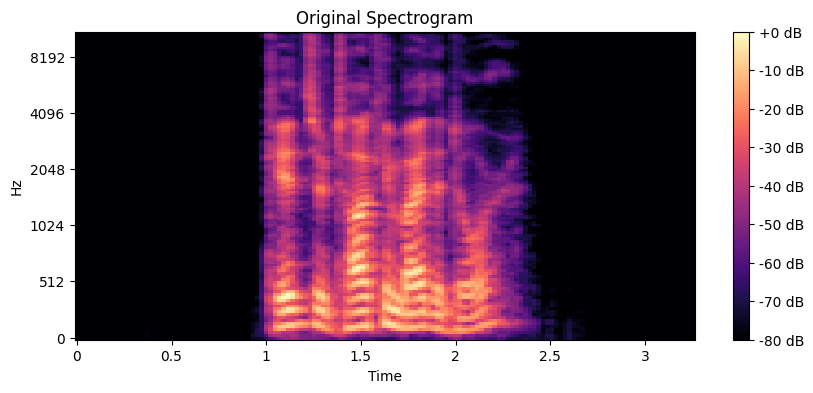

TypeError: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given

In [52]:
def plot_spectrogram(y, sr, title):
    plt.figure(figsize=(10, 4))
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, x_axis="time", y_axis="mel")
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.show()

# Load a random file and augment
random_file = os.path.join(data_path, "Actor_01", random.choice(os.listdir(os.path.join(data_path, "Actor_01"))))
y, sr = librosa.load(random_file, sr=22050)

# Plot original
plot_spectrogram(y, sr, "Original Spectrogram")

# Augment and plot
def augment_audio(y, sr):
    if np.random.rand() > 0.5:
        y = librosa.effects.time_stretch(y, rate=np.random.uniform(0.8, 1.2))
    if np.random.rand() > 0.5:
        y = librosa.effects.pitch_shift(y, sr, n_steps=np.random.randint(-2, 2))
    return y

y_aug = augment_audio(y, sr)
plot_spectrogram(y_aug, sr, "Augmented Spectrogram")


In [53]:
num_classes = len(label_encoder.classes_)

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(100, 40)))
model.add(BatchNormalization())  
model.add(Dropout(0.5))  

model.add(LSTM(64))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  # Output layer

# Compile with reduced learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Model summary
model.summary()


c:\Users\anujk\Documents\MIT\MIT3Year\DL_Lab\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 100, 128)       │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,800 (569.53 KB)

 Trainable params: 145,544 (568.53 KB)

 Non-trainable params: 256 (1.00 KB)

In [57]:
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=200, 
                    batch_size=32)


Epoch 1/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - accuracy: 0.5907 - loss: 1.5088 - val_accuracy: 0.4861 - val_loss: 1.8123
Epoch 2/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step - accuracy: 0.6378 - loss: 1.4317 - val_accuracy: 0.4931 - val_loss: 1.8113
Epoch 3/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - accuracy: 0.6112 - loss: 1.4374 - val_accuracy: 0.5000 - val_loss: 1.7754
Epoch 4/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step - accuracy: 0.6386 - loss: 1.3586 - val_accuracy: 0.5000 - val_loss: 1.7750
Epoch 5/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.6407 - loss: 1.3931 - val_accuracy: 0.4896 - val_loss: 1.7784
Epoch 6/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.6367 - loss: 1.3791 - val_accuracy: 0.5035 - val_loss: 1.7853
Epoch 7/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.6461 - loss: 1.3869 - val_accuracy: 0.5208 - val_loss: 1.7735
Epoch 8/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.6494 - loss: 1.3231 - val_acc

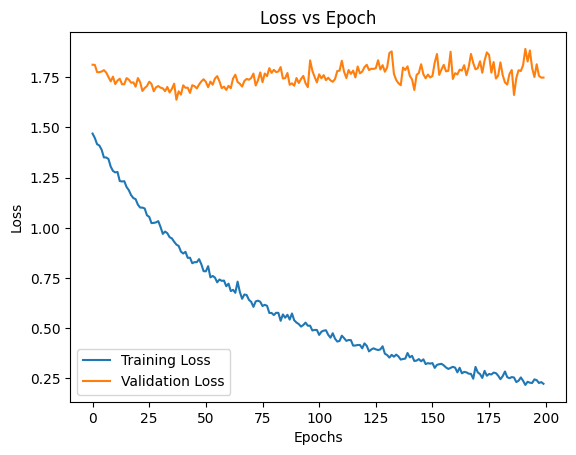

In [58]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epoch')
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


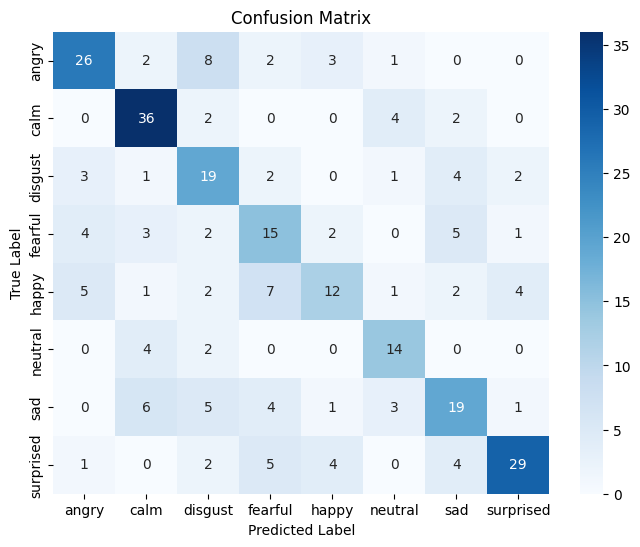

In [60]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [17]:

# plt.figure(figsize=(8, 6))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Loss vs Epoch')
# plt.show()
